# Detroit Blight Compliance
This interactive notebook will build a classifier for classifying whether or not an issued blight ticket in the city of Detroit gets paid. Training and testing data was sourced from [Detroit's Open Data Portal](https://data.detroitmi.gov).

First, we'll do some preprocessing of the data.

In [2]:
import numpy as np
import pandas as pd
import re
pd.options.mode.chained_assignment = None  # default='warn'

cols_to_keep = ['ticket_id','fine_amount','inspector_name', 
				'violator_name','agency_name','violation_date','disposition',
				'violation_code','hearing_date','parcelno','X','Y','balance_due']

blight_data = pd.read_csv( 'Blight_Violations.csv', usecols = cols_to_keep).set_index('ticket_id')

blight_data.drop_duplicates(inplace = True)
blight_data.head()

,X,Y,agency_name,inspector_name,violator_name,violation_date,hearing_date,violation_code,disposition,fine_amount,balance_due,parcelno
ticket_id,,,,,,,,,,,,
202030,-82.947311,42.359524,"Buildings, Safety Engineering & Env Department",Gregory Siller,ADAM KORETSZA,2009-01-08T00:00:00.000Z,2009-02-06T00:00:00.000Z,61-4-32,Not responsible by Determination,750.0,0.0,21000091-2
310207,-82.987194,42.398657,BSEED Environmental Affairs,Aisha Granberry,GWENDOLYN BURNETTE,2013-12-09T00:00:00.000Z,2014-01-09T00:00:00.000Z,22-2-43,Not responsible by City Dismissal,100.0,0.0,21005108.
50270,-83.238200,42.345750,Health Department,Eric Brooks,George Matthew,2005-09-22T00:00:00.000Z,2005-11-30T00:00:00.000Z,9-1-105,Responsible by Default,100.0,130.0,22099985.
376747,-82.926914,42.397969,"Buildings, Safety Engineering & Env Department",Wesley Bush,Micheal Eisemann,2017-01-06T00:00:00.000Z,2017-04-28T00:00:00.000Z,9-1-36(a),Not responsible by City Dismissal,250.0,0.0,21073910.
238466,-83.107788,42.316641,"Buildings, Safety Engineering & Env Department",Bennie Sloane,TERESA REYES,2009-12-03T00:00:00.000Z,2010-03-22T00:00:00.000Z,9-1-81(a),Not responsible by Dismissal,250.0,0.0,16016404.


Now we'll incorporate time data so that we can keep track of which years the tickets were issued.

In [19]:
def get_time_features(index_to_drop,label_flag, data):

	datetime = pd.to_datetime(data[ index_to_drop ].astype(str), infer_datetime_format = True).dt
	data[label_flag+'_year'] = datetime.year
	data[label_flag+'_month'] = datetime.month
	data[label_flag+'_day'] = datetime.day
	data[label_flag+'_weekday'] = datetime.weekday
	data.drop(columns = index_to_drop, inplace = True)
	return data

blight_data = get_time_features('violation_date', 'issued', blight_data)
blight_data = get_time_features('hearing_date', 'hearing', blight_data)

We'll keep only data from the years 2009 through (and including) 2018. Ultimately, data from the last two years will be our test set.

In [20]:
blight_data = blight_data[blight_data['issued_year']>=2009]
blight_data = blight_data[blight_data['issued_year']<=2018]

We'll use the `balance_due` feature to indicate whether or not the blight ticket was paid.

In [21]:
blight_data['compliance'] = blight_data['balance_due'].apply(lambda x: 0 if x>0.0 else 1 )
blight_data.drop(columns = ['balance_due','hearing_year'], inplace = True)

We'll need to use the parcel data to access more information about a particular property, e.g. assessed value, zoning, etc. However, some of the data does not have a parcel number associated to the ticket. We'll try to interpolate this missing data by retrieving parcel data from a nearby parcel. First we need to find the data that is missing a valid parcel number.

In [22]:
#first, we should drop the missing location data from the data set (there are only 82 entries missing this data).
blight_data.dropna(axis = 0, subset = ['X','Y'], inplace = True)

#next, we'll include the parcel data
parcel_cols_to_keep = ['ward', 'year_built', 'assessed_value', 'zoning', 'parcel_number']
parcel_data = pd.read_csv('Parcels.csv', usecols = parcel_cols_to_keep)
parcel_data.drop_duplicates(subset = 'parcel_number',inplace= True)
parcel_data.set_index('parcel_number', inplace = True)
valid_parcel_codes = set(list(parcel_data.index))

#these commands are used to save the coordinates of tickets that need parcel numbers
#need_parcels = blight_data[['X','Y']].loc[~blight_data['parcelno'].isin(valid_parcel_codes)]
#need_parcels.to_csv(path_or_buf = 'need_parcels.csv')

Unfortunately, there's a lot of missing data in the parcel data set. We'll need the `year_built` and `assessed_value` features, but some of the data is missing (or has zero as a value). Where this data is missing, we'll replace it with the average year or value of the structures with the same zoning designation.

In [23]:
#group by the ward and zoning, then compute the avg data:
grouped = parcel_data.groupby(['zoning'])
avg_year_built = grouped['year_built'].mean()

#some of the zoning data is missing, so we'll only update based off of zoning data that 
#isn't missing
mask = ~parcel_data['zoning'].isnull()

parcel_data.loc[mask,'avg_year_built'] = parcel_data.loc[mask].index.map(lambda x: avg_year_built.loc[  parcel_data.at[x, 'zoning']   ]) 
parcel_data['year_built'] = parcel_data['year_built'].where(parcel_data['year_built'].isnull() | parcel_data['year_built']==0.0, parcel_data['avg_year_built'])

avg_value = grouped['assessed_value'].mean()

parcel_data.loc[mask,'avg_val'] = parcel_data.loc[mask].index.map(lambda x: avg_value.loc[  parcel_data.at[x, 'zoning']   ]) 
parcel_data['assessed_value'] = parcel_data['assessed_value'].where(parcel_data['assessed_value'].isnull() | parcel_data['assessed_value']==0.0, parcel_data['avg_val'])

Now we've used the Google Maps API to look up the address of the tickets that do not have parcel numbers. We then used this address to find the address in the parcel data that best matches the address provided by Google's API. We've saved this data in the file `ticket_id_to_parcel_dict.csv`. We'll import this as a dataframe and then merge the blight_data with the parcel data. 

In [24]:
ticket_id_to_parcel = pd.read_csv('ticket_id_to_parcel_dict.csv').set_index(keys = 'ticket_id')
blight_data['padded_parcels'] = ticket_id_to_parcel
blight_data['parcelno'].where(blight_data['parcelno'].isin(valid_parcel_codes), blight_data['padded_parcels'], inplace=True)
blight_data.drop(columns = 'padded_parcels', inplace = True)
blight_data['ticket_no'] = blight_data.index
blight_data = blight_data.merge(parcel_data, left_on = 'parcelno', right_on = 'parcel_number', how = 'inner')

In [25]:
blight_data = blight_data.set_index(keys = 'ticket_no')
blight_data.drop(columns = ['avg_year_built','avg_val'], inplace = True)
#drop the rest of the missing data that can't be recovered:
blight_data = blight_data[~blight_data.isnull().any(axis = 1)]


#save the completed data to a csv file
#blight_data.to_csv(path_or_buf = 'processed_blight_data.csv')

The last bit of data we'll incorporate is crime data. We'll integrate crime data and engineer the following feature: For a given address, we'll total all the reported crime instances within the $||\cdot||_1$-ball of radius 1km of the Lat/Lon coordinate of the address. To do this, we need to approximate the distances. We'll use a linear approximation:

In [3]:
#I ran this "off camera" because it took a while.
'''
from math import pi

avg_lat = blight_data['Y'].median()*(pi/180.0)

#these two variables give the instantaneous rate of change the distance (in m) as a function of latitude
delta_lat = 111132.92 - 559.822*np.cos(2*avg_lat)+1.175*np.cos(4*avg_lat)-0.0023*np.cos(6*avg_lat)
delta_lon =  111412.84*np.cos(avg_lat)-93.5*np.cos(3*avg_lat)+0.118*np.cos(5*avg_lat)

crime_data = pd.read_csv('Reported_Major_Crimes_2011_to_2014.csv', usecols = ['LOCATION'])

#clean crime data to obtain only latitude and longitude information. 
crime_data['lat'] = crime_data['LOCATION'].str.extract(r'\(([0-9,.]+),').astype(float)
crime_data['lon'] = crime_data['LOCATION'].str.extract(r', ([0-9,.,-]+)\)').astype(float)
crime_data.drop(columns = ['LOCATION'], inplace = True)

tot_crimes = crime_data['lat'].size

blight_data['loc'] =  list( zip(blight_data.Y, blight_data.X) ) 
crime_lat = crime_data['lat'].to_numpy()
crime_lon = crime_data['lon'].to_numpy()

def crime_tally(loc):
    return np.sum( delta_lat*np.absolute( (loc[0])*np.ones(tot_crimes) - crime_lat )+ \
    delta_lon*np.absolute( (loc[1])*np.ones(tot_crimes) - crime_lon ) <= 1000.0 )

blight_data['loc'].sample(frac = 0.1).apply(crime_tally)
'''
blight_data = pd.read_csv('processed_blight_data_with_crime.csv').set_index('ticket_no')

#standardize the string data by making everything lowercase and removing punctuation

def standardize_text(index, data):

	standard = data[ index ].astype(str).map(lambda x: x.lower().strip())
	standard = standard.map(lambda x: re.sub(r'[^\w\s]','', x))

	data[ index ] = standard

	return data

blight_data = standardize_text('agency_name', blight_data)
blight_data = standardize_text('inspector_name', blight_data)
blight_data = standardize_text('violator_name', blight_data)

#the `disposition` feature appears to be *highly* correlated with the the target value. 
#To avoid data leakage, we'll remove that feature and then shuffle the dataset.
blight_data.drop(columns = 'disposition', inplace = True)
blight_data = blight_data.sample(frac = 1)

### Incorporating categorical data:
There are five categorical features. We need to encode these to build our model. First we'll take care of the easier categorical features that have relatively few categories. 

In [4]:
categorical_features = ['agency_name', 'inspector_name', 'violator_name', 'violation_code', 'zoning']

[blight_data[feature].value_counts().size for feature in categorical_features]

[3, 216, 98120, 254, 27]

So the features `agency_name` and `zoning` don't have many categories. There are so few we could even take a look:

In [59]:
print(blight_data['agency_name'].value_counts())
print(blight_data['zoning'].value_counts())

bseed environmental affairs                     111156
buildings safety engineering  env department    101749
detroit police department                        10592
Name: agency_name, dtype: int64
R1     105490
R2      53570
B4      32570
B2       6184
R3       6065
M4       5237
R5       3663
PD       1724
M3       1617
M2       1478
B5       1408
B3        952
R6        808
SD2       695
SD4       433
PCA       351
B6        327
R4        316
SD1       259
M5        105
B1         75
P1         71
PC         51
SD5        31
PR         13
W1          2
TM          2
Name: zoning, dtype: int64


Since there are a few spurious `zoning` features, we'll just bin building codes that appeared fewer than 100 times into an `other` category.

In [5]:
spurious_codes = ['B1', 'P1', 'PC', 'SD5', 'PR', 'TM', 'W1']
blight_data.loc[:,'zoning'] = blight_data.loc[:,'zoning'].where(~blight_data.loc[:,'zoning'].isin(spurious_codes), 'other')

We'll encode these categorical features with one-hot encoding. The three remaining categorical features will get encoded either using target or rank encoding. To avoid data leakage, we'll split the data into the training and test sets before doing this encoding. 

In [6]:
training_data = blight_data[blight_data['issued_year']<2017]
test_data = blight_data[blight_data['issued_year']>=2017]

Now we'll focus on the four remaining categorical features. We'll start with looking at the violator name and violation codes. As seen previously, there are 98120 violator names and 254 different violator codes. In the case of violator names, there are too many to use one-hot encoding. So instead we'll consolidate these. First, we'll check the counts of each particular value and make a plot ranking the cumulative portion of tickets a given set of violator codes accounts for. 

Text(0, 0.5, 'Proportion of tickets with these violation codes')

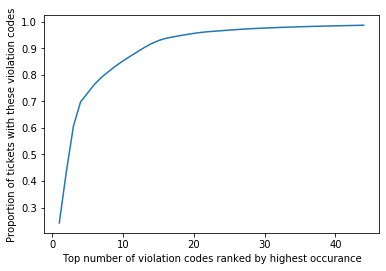

In [62]:
import matplotlib.pyplot as plt

violation_code_counts = training_data['violation_code'].value_counts().sort_values()
x = np.arange(1,45)
plt.plot(x, [violation_code_counts[-x[i-1]:].sum()/violation_code_counts.sum() for i in x])
plt.xlabel('Top number of violation codes ranked by highest occurance')
plt.ylabel('Proportion of tickets with these violation codes')

Given the plot above, it looks safe to keep the top 14 violator codes ranked by number of tickets and then consolidate the remaining codes by binning them together into one label called `other`.

In [7]:
codes_to_keep = training_data['violation_code'].value_counts().sort_values()[-14:].index.values
training_data['violation_code'] = training_data.loc[:,'violation_code'].apply(lambda x: x if x in codes_to_keep else 'other' )

Let's apply the same analysis to the inspector names: 

Text(0, 0.5, 'Proportion of tickets issued from these inspectors')

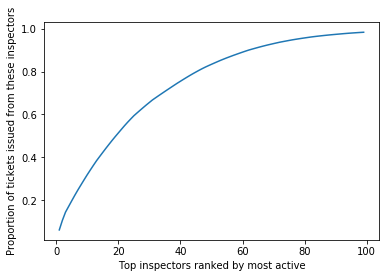

In [64]:
inspector_counts = training_data['inspector_name'].value_counts().sort_values()
x = np.arange(1,100)
plt.plot(x, [inspector_counts[-x[i-1]:].sum()/inspector_counts.sum() for i in x])
plt.xlabel('Top inspectors ranked by most active')
plt.ylabel('Proportion of tickets issued from these inspectors')

Not entirely clear where to cut off the inspector names. Instead, we'll replace the inspector with the inspector's success rate. For every inspector that gave out at least 100 tickets we'll compute that inspector's successful compliance rate and replace the inspector data with this rate. So we're engineering the categorical feature into a numerical one. For inspectors that gave out fewer than 100 tickets, we'll set their rate to 0.63 (which is the average rate of blight ticket compliance). 

In [8]:
insp_val_counts =  training_data['inspector_name'].value_counts()
grouping = training_data.groupby('inspector_name')

inspector_compliance_perc = grouping['compliance'].mean()
training_data.loc[:,'inspector_perc_success'] = training_data.loc[:,'inspector_name'].apply(lambda x: inspector_compliance_perc.loc[x] if (insp_val_counts.loc[x]>100) else 0.63)
training_data.drop(columns = 'inspector_name', inplace = True)

We start applying the same analysis to the `violator_name` category.

Text(0, 0.5, 'Proportion of tickets issued to these violators')

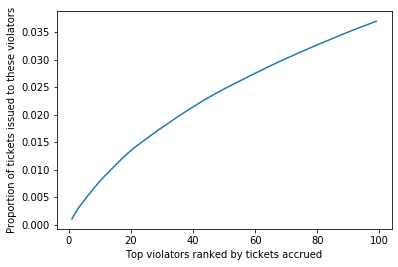

In [66]:
violator_counts = training_data['violator_name'].value_counts().sort_values()
x = np.arange(1,100)
plt.plot(x, [violator_counts[-x[i-1]:].sum()/violator_counts.sum() for i in x])
plt.xlabel('Top violators ranked by tickets accrued')
plt.ylabel('Proportion of tickets issued to these violators')

Similar to the `inspector_name` category, we cannot use the binning approach. Instead, we'll use count encoding to convert the violator name to the number of times that violator recieved a blight ticket. 

In [9]:
viol_val_counts =  training_data['violator_name'].value_counts(dropna = False)

training_data.loc[:,'violator_count'] = training_data.loc[:,'violator_name'].apply(lambda x: viol_val_counts.loc[x])
training_data.drop(columns = 'violator_name', inplace = True)

## Fitting a gradient boosted decision tree classifier
We're ready to fit a model with our training data. We start by removing the labels from the training data and one-hot encoding the remaining categorical features.

In [10]:
X = training_data.drop(columns= ['compliance'], axis = 1)
Y = training_data['compliance']

#use one-hot encoding for `agency_name` and `violation_code` and `zoning`. 
X = pd.get_dummies(X, columns = ['agency_name', 'violation_code','zoning'])

In [ ]:
#end preprocessing; Do grid search:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

grid_values = {'n_estimators': [5,10], 'learning_rate': [0.1,0.01], 'max_depth':[6,7,8]}

gbc = GradientBoostingClassifier()

roc_grid = GridSearchCV(gbc, param_grid = grid_values, scoring = 'roc_auc', cv = 4)

roc_grid.fit(X,Y)

grid_data = pd.DataFrame(roc_grid.cv_results_)
mean_test_scores = grid_data.set_index('params')['mean_test_score']

print(mean_test_scores.values.reshape(2,2,3))

Given the grid search, it looks like we should train a gradient boosted decision tree ensemble with parameters: `n_estimators = 5`, `learning_rate = 0.01` and `max_depth = 7`.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 7, n_estimators = 5)
gbc.fit(X,Y)

y_score = gbc.predict_proba(X)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc_score(Y, y_score[:,1])

0.7224323761025311

Now we'll encode the categorical data in the test set using the encodings from the training set.

In [13]:
#use the popular codes from the test set:
test_data.loc[:,'violation_code'] = test_data.loc[:,'violation_code'].apply(lambda x: x if x in codes_to_keep else 'other' )

# encode the inspector's success rate:
insp_val_counts =  test_data['inspector_name'].value_counts()
grouping = test_data.groupby('inspector_name')

inspector_compliance_perc = grouping['compliance'].mean()
test_data.loc[:,'inspector_perc_success'] = test_data.loc[:,'inspector_name'].apply(lambda x: inspector_compliance_perc.loc[x] if (insp_val_counts.loc[x]>100) else 0.63)
test_data.drop(columns = 'inspector_name', inplace = True)

#use the violator counts from the training set:
test_data.loc[:,'violator_count'] = test_data.loc[:,'violator_name'].apply(lambda x: viol_val_counts.loc[x] if (x in viol_val_counts.index) else viol_val_counts.mean())
test_data.drop(columns = 'violator_name', inplace = True)

In [14]:
X_test = test_data.drop(columns= ['compliance'], axis = 1)
Y_test = test_data['compliance']

#use one-hot encoding for `agency_name` and `violation_code` and `zoning`. 
X_test = pd.get_dummies(X_test, columns = ['agency_name', 'violation_code','zoning'])

In [15]:
y_test_score = gbc.predict_proba(X_test)
roc_auc_score(Y_test, y_test_score[:,1])

0.5853365139479605

It's interesting (and a little disappointing) that the ROC score for the test data is much worse than the ROC score for the training data. This could be for a variety of reasons. First, perhaps the parameters above for our gradient boosted classifier have caused us to overfit the training data. Second, it is possible that we're seeing "drift," i.e. that the more recent data is governed by a probability distribution with different parameters. This could be investigated more by say, doing some hypothesis testing or comparing statistics for the training and test set. One easy statistic to look at is the percentage of blight ticket compliance. For the test set, average compliance is more than 10% lower than the average compliance for the training set. Either way, it's useful to look at the ROC curves for our model.

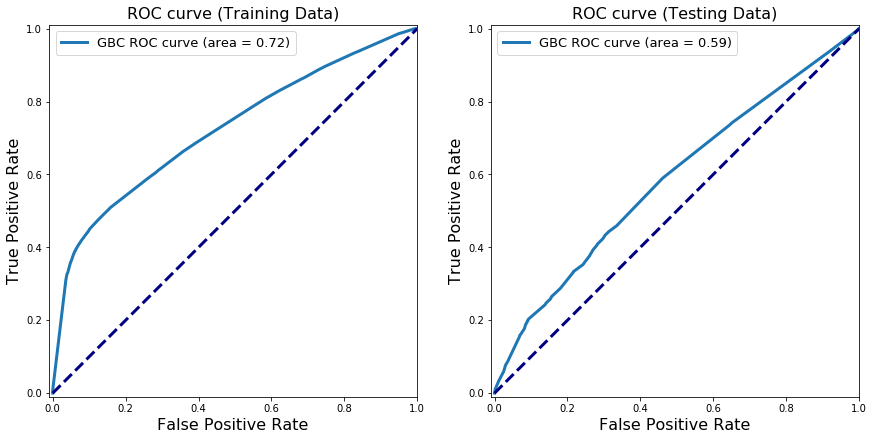

In [91]:
fpr, tpr, _ = roc_curve(Y, y_score[:,1])
fprt, tprt, _ = roc_curve(Y_test, y_test_score[:,1])

fig,a =  plt.subplots(1,2)
a[0].set_xlim([-0.01, 1.00])
a[0].set_ylim([-0.01, 1.01])
a[0].plot(fpr, tpr, lw=3, label='GBC ROC curve (area = 0.72)')
a[0].set_xlabel('False Positive Rate', fontsize=16)
a[0].set_ylabel('True Positive Rate', fontsize=16)
a[0].set_title('ROC curve (Training Data)', fontsize=16)
a[0].legend(loc='best', fontsize=13)
a[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
a[0].set_aspect('equal')

a[1].set_xlim([-0.01, 1.00])
a[1].set_ylim([-0.01, 1.01])
a[1].plot(fprt, tprt, lw=3, label='GBC ROC curve (area = 0.59)')
a[1].set_xlabel('False Positive Rate', fontsize=16)
a[1].set_ylabel('True Positive Rate', fontsize=16)
a[1].set_title('ROC curve (Testing Data)', fontsize=16)
a[1].legend(loc='best', fontsize=13)
a[1].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
a[1].set_aspect('equal')
plt.subplots_adjust(bottom=0.1, right=2.0, top=1.5)

plt.show()

Here are the top 10 most important features:

In [109]:
importance_ = gbc.feature_importances_

feature_importance = zip(X.columns.values, importance_)
feature_importance = pd.DataFrame(list(feature_importance), columns = ['feature', 'importance']).set_index('feature')

sorted_features = feature_importance.sort_values(by = 'importance',ascending = False)
sorted_features.index.values[0:10]

array(['assessed_value', 'inspector_perc_success', 'zoning_B4', 'Y',
       'hearing_weekday', 'violator_count', 'X', 'year_built', 'ward',
       'crime_totals'], dtype=object)

Many of these important features are not very surprising. For instance, it makes sense that the assessed value, the location data, neighborhood and crime data are important factors for determining whether a given ticket will be paid. However, there are some surprising features in this list. For instance, it appears that certain inspectors really are better than others at facilitating compliance. With this knowledge, we could interview successful inspectors and try to produce general guidelines to all inspectors based off of the successful inspectors' feedback. The fact that the day of the week a given blight ticket is issued is important for determining compliance is genuinely surprising at first. However, I suspect this is another manifestation of the fact that certain inspectors are better than others at facilitating compliance. To confirm this, we can averge the hearing weekday feature across the inspectors. We see in the output below that the inspectors appear to only show up to court on certain days. So the `hearing_weekday` feature is just helping detect whether a particular blight ticket came from an instructor that's good at facilitating compliance or not. 

In [114]:
blight_data.groupby('inspector_name')['hearing_weekday'].mean().sort_values()

inspector_name
raymond  berendt    0.0
della brown         0.0
lashanna mcghee     0.0
bryan bahm          0.0
trevis  anderson    0.0
                   ... 
cecila williams     4.0
rolland wilkins     4.0
darnell johnson     4.0
joseph corbett      4.0
melanie malone      4.0
Name: hearing_weekday, Length: 216, dtype: float64